# Time Series Augmentations with TSGM

Augmentations have become an indispensable component in the realm of computer vision pipelines. However, their popularity hasn't reached the same heights in other domains, such as time series. In this tutorial, I will delve into the world of time series augmentations, shedding light on their significance and providing concrete examples of their application using the powerful generative time series modeling library, TSGM.

Our starting point is a dataset denoted $(X, y)$. Here, $x_i \in X$ are multivariate (meaning, each time point is a multiple dimensional feature vector) time series, and $y$ are labels. Predicting labels $y$ is called a downstream task. Our goal is to use $(X, y)$ to produce additional samples $(\hat{X}, \hat{y})$, which could help us solve the downstream task more effectively (in terms of predictive performance or robustness). For simplicity, we won't work with labels in this tutorial, but the methods we describe here are straightforward to generalize to the case with labels, and the software implementations we use are easily extended to the supervised case by adding additional parameters to the `.generate` method (see examples below).

Moving forward, we import tsgm, and load an exemplary dataset. A tensor `X` now contains 100 sine time series of length 64, with 2 features each. With random shift, frequencies, and amplitudes (maximum amplitude is 20).

In [1]:
!pip install tsgm -q

In [3]:
%load_ext autoreload
%autoreload 2
from IPython.display import SVG, display, Image

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tensorflow import keras

import tsgm


def plot(timesteps, X, plot_id=1, title="Original"):
    plt.subplot(1, 2, plot_id)
    for sample_id in range(X.shape[0]):
        plt.plot(timesteps, X[sample_id, :, 0], label=f"Sample #{sample_id}")
    plt.title(title)
    plt.legend()


def plot_samples_aug(X, Xaug, n_samples=5):
    timesteps = np.arange(0, X.shape[1], 1)
    sample_ids = random.sample(range(X.shape[0]), n_samples)
    sample_ids_aug = random.sample(range(Xaug.shape[0]), n_samples)

    plot(timesteps, X[sample_ids])
    plot(timesteps, Xaug[sample_ids_aug], title="Synthetic", plot_id=2)
    plt.show()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
X = tsgm.utils.gen_sine_dataset(100, 64, 2, max_value=20)

## Jittering / Gaussian noise

Time series data are augmented with random Gaussian noise ([Wikipedia](https://en.wikipedia.org/wiki/Gaussian_noise))

$$x_i = x_i + \mathcal{N}(0, \sigma).$$

In tsgm, Gaussian noise augmentation can be applied as follows:


In [5]:
aug_model = tsgm.models.augmentations.GaussianNoise()
samples = aug_model.generate(X=X, n_samples=10, variance=0.2)

The idea behind Gaussian noise augmentation is that adding a small amount of jittering to time series probably will not change it significantly but will increase the amount of such noisy samples in our dataset. It often makes the downstream models more robust to noisy samples or improves predictive performance.
The hyperparameters of Gaussian noise and the way of adding the noise (e.g., Gaussian noise can increase towards the end of a time series) is a difficult question and depends on a particular dataset and downstream problem. It is often worth experimenting and seeing how those parameters affect the performance of the target model.
Here, we provide a visualization of samples from the original sine dataset and augmented samples.

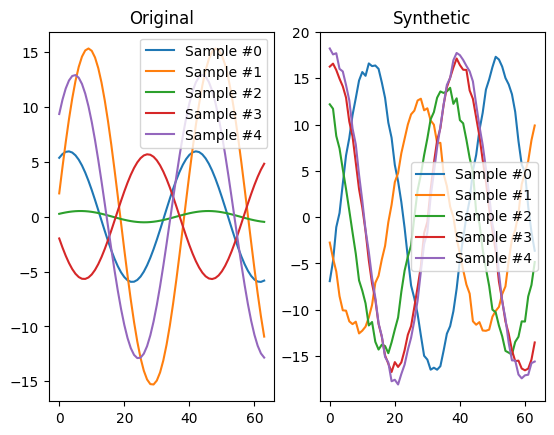

In [6]:
plot_samples_aug(X, samples)

## Shuffle Features

Another approach to time series augmentation is simply shuffly the features. This approach is suitable only for particular multivariate time series, where they are invariant to all or particular permutations of features. For instance, it can be applied to time series where each feature represents same independent measurements from various sensors.

To illustrate this method, let us consider 5 identical sensors ($S_1, S_2, S_3, S_4, \text{and } S_5$). We can see that sensors 1-4 are probably exchangeable with respect to rotation. Then it makes sense to try augmenting data with feature shufle with respect to rotations of $S_1, \ldots, S_4$ sensors.

Similarly to the previous example, the augmentation can work as follows:

In [7]:
aug_model = tsgm.models.augmentations.Shuffle()
samples = aug_model.generate(X=X, n_samples=3)

Here, we show one sample from a timeseries with 5 features, and an augmented sample, analogously to the image above.

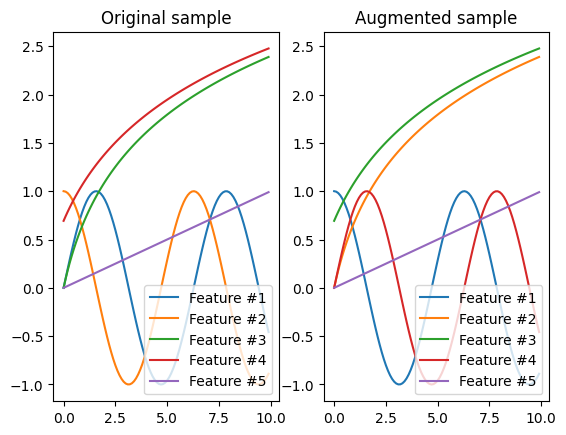

In [8]:
timesteps = np.arange(0, 10, 0.1)
sample = np.stack([np.sin(timesteps), np.cos(timesteps), np.log(timesteps + 1), np.log(timesteps + 2), timesteps / 10])
plt.subplot(1, 2, 1)
for feature_id in range(5):
    plt.plot(timesteps, sample[feature_id], label=f"Feature #{feature_id + 1}")
plt.title("Original sample")
plt.legend()

permutation = [1, 2, 3, 0, 4]
sample = sample[permutation]
plt.subplot(1, 2, 2)
for feature_id in range(5):
    plt.plot(timesteps, sample[feature_id], label=f"Feature #{feature_id + 1}")
plt.title("Augmented sample")
plt.legend()
plt.show()

## Slice and shuffle

Slice and shuffle augmentation [3] cuts a time series into slices and shuffles those pieces. This augmentation can be performed for time series that exhibit some form of invariance over time. For instance, imagine a time series measured from wearable devices for several days. The good strategy for this case is to slice time series by days and, by shuffling those days, get additional samples.

In [9]:
aug_model = tsgm.models.augmentations.SliceAndShuffle()
samples = aug_model.generate(X=X, n_samples=10, n_segments=3)

Let's view augmented and original samples as a visualization:

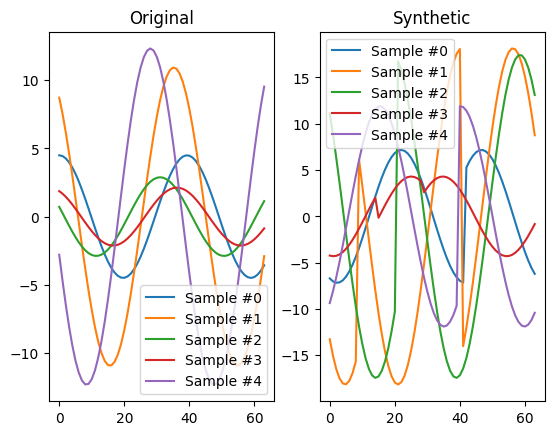

In [10]:
plot_samples_aug(X, samples)

## Magnitude Warping

Magnitude warping [3] changes the magnitude of each sample in a time series dataset by multiplication of the original time series with a cubic spline curve. This process scales the magnitude of time series, which can be beneficial in many cases, such as our synthetic example with sines `n_knots` number of knots at random magnitudes distributed as $\mathcal{N}(1, \sigma)$ where $\sigma$ is set by a parameter `sigma` in function `.generate`.

In [11]:
aug_model = tsgm.models.augmentations.MagnitudeWarping()
samples = aug_model.generate(X=X, n_samples=10, sigma=1)

Here is an example of original data and augmented samples generated with `MagnitudeWarping`.

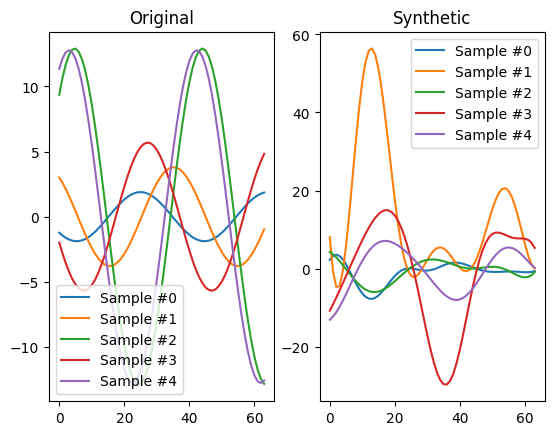

In [12]:
plot_samples_aug(X, samples)

## Window Warping

In this technique [4], the selected windows in time series data are either speeding up or down. Then, the whole resulting time series is scaled back to the original size in order to keep the timesteps at the original length.

Such augmentation can be beneficial, e.g., in modeling equipment. In such applications, sensor measurements can change the speed of change depending on how those pieces of equipment are used.


In tsgm, as always, the generation can be done via

In [13]:
aug_model = tsgm.models.augmentations.WindowWarping()
samples = aug_model.generate(X=X, n_samples=10, scales=(0.5,), window_ratio=0.5)

An example of a generated time series can be found below.

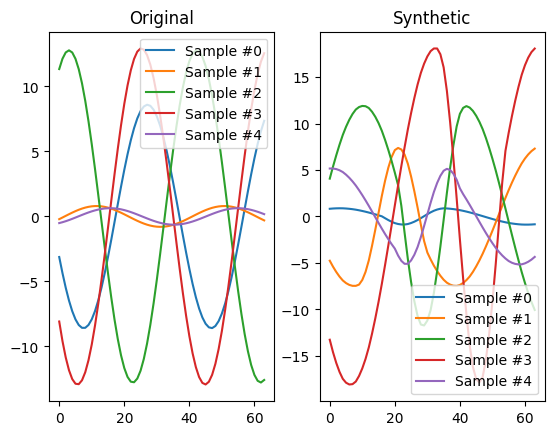

In [14]:
plot_samples_aug(X, samples)

## Dynamic Time Warping Barycentric Average (DTWBA)

Dynamic Time Warping Barycentric Average (DTWBA)[2] is an augmentation method that is based on Dynamic Time Warping (DTW). DTW is a method of measuring similarity between time series.

Here, DTW is measured for two time series signals $\sin(x)$ and $\sin(2x)$. DTW measurement is shown with the white line. Also, a cross-similarity matrix is visualized.

In [15]:
aug_model = tsgm.models.augmentations.DTWBarycentricAveraging()
initial_timeseries = random.sample(range(X.shape[0]), 10)
initial_timeseries = X[initial_timeseries]
samples = aug_model.generate(X=X, n_samples=10, initial_timeseries=initial_timeseries )

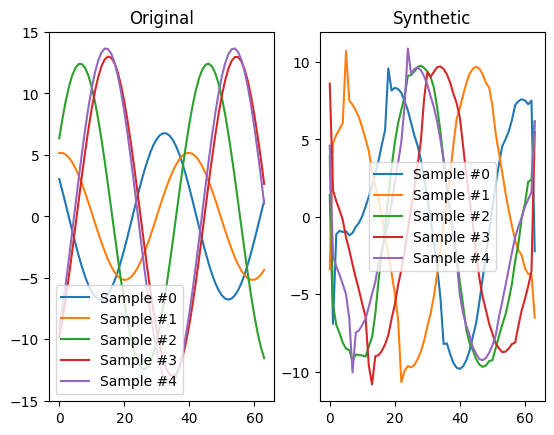

In [16]:
plot_samples_aug(X, samples)

## Augmentation with generative machine learning models

Another approach to augmentation is to train a machine learning model on historical data and train it to generate novel synthetic samples. It is a blackbox method because it is hard to interpret how new samples were generated. Several methods can be applied in the case of time series; in particular, tsgm has VAE, GANs, and Gaussian processes. An example of the generation of synthetic time series with VAEs is

In [17]:
n, n_ts, n_features = 1000, 24, 5
data = tsgm.utils.gen_sine_dataset(n, n_ts, n_features)
scaler = tsgm.utils.TSFeatureWiseScaler()
scaled_data = scaler.fit_transform(data)
architecture = tsgm.models.zoo["vae_conv5"](n_ts, n_features, 10)
encoder, decoder = architecture.encoder, architecture.decoder
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(scaled_data, epochs=1, batch_size=64)
samples = vae.generate(10)

16/16 [==============================] - 9s 257ms/step - loss: 300.4675 - reconstruction_loss: 290.7053 - kl_loss: 2.2801
